## Options and Libraries

In [214]:
# this will make sure the root folder is the current working directory
from os import chdir, getcwd
from pyprojroot.here import here
chdir(here())
getcwd()

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [215]:
# main libs
import pandas as pd
import numpy as np

# graphic libs
from matplotlib import pyplot as plt
import seaborn as sns

# set theme for plots
sns.set_theme()

## Read data

In [216]:
df = pd.read_parquet("data/02_inter/df_01_first_look.parquet")
# data with minor modifications from 01_eda_first_look.ipynb

# one hot
df_full_dummies = pd.get_dummies(df, drop_first=True)

# Convert to integer days since 1970-01-01 (unix epoch)
df_full_dummies['dt_customer'] = (df_full_dummies['dt_customer'] - pd.Timestamp('1970-01-01')).dt.days

df_full_dummies = df_full_dummies.drop(columns=[
    "response",
    "income_pred",
    "year_birth",
    "income_error", 
    "income_error_relative"
])

df_unscaled = df_full_dummies[[
    'age',
    'education_years',
    'income',
    'kidhome',
    'teenhome',
    'marital_status_simple_Single',
    
    'mnt_wines',
    'mnt_fruits',
    'mnt_meat',
    'mnt_fish',
    'mnt_sweet',
    'mnt_gold',
    'mnt_total',
    
    'recency',

    
    'num_deals',
    'num_web',
    'num_catalog',
    'num_store',
    'num_web_visits_month',
    'num_total',
    
    'accepted_total',
    ]]

In [217]:
# dropping some columns for "more targeted model"
regex_drop = r"error"
drop_cols = df_unscaled.filter(regex=regex_drop).columns

print(drop_cols)
df_unscaled.drop(columns=drop_cols, inplace=True)

Index([], dtype='object')


## K-Means Clustering

In [218]:
from sklearn.preprocessing import StandardScaler
df_scaled = StandardScaler().fit_transform(df_unscaled)
df_scaled = pd.DataFrame(df_scaled, columns = df_unscaled.columns)
df_scaled.head(6)

,age,education_years,income,kidhome,teenhome,marital_status_simple_Single,mnt_wines,mnt_fruits,mnt_meat,mnt_fish,mnt_sweet,mnt_gold,mnt_total,recency,num_deals,num_web,num_catalog,num_store,num_web_visits_month,num_total,accepted_total
0,1.012850,-0.350051,0.268102,-0.825218,-0.929894,1.346874,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,1.679417,0.307039,0.366793,1.491860,2.665261,-0.550785,0.741693,1.621229,-0.439037
1,1.268812,-0.350051,-0.328001,1.032559,0.906934,1.346874,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.961275,-0.383664,-0.168114,-1.157932,-0.591401,-1.166125,-0.123340,-1.258779,-0.439037
2,0.330284,-0.350051,0.949167,-0.825218,-0.929894,-0.742460,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,0.282673,-0.798086,-0.703020,1.491860,-0.229549,1.295237,-0.555856,0.661226,-0.439037
3,-1.290811,-0.350051,-1.323595,1.032559,-0.929894,-0.742460,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,-0.918094,-0.798086,-0.168114,-0.779390,-0.953252,-0.550785,0.309177,-0.847349,-0.439037
4,-1.034849,1.557769,0.275936,1.032559,-0.929894,-0.742460,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,-0.305254,1.550305,1.436606,0.356235,0.132302,0.064556,-0.123340,0.524083,-0.439037
5,0.159642,0.285889,0.489227,-0.825218,0.906934,-0.742460,0.642051,0.394768,-0.305541,-0.687068,0.361924,-0.575619,0.183025,-1.143438,-0.168114,0.734776,0.494153,1.295237,0.309177,1.072656,-0.439037


In [219]:
# for both models
n_clusters = 3

In [220]:
from sklearn.cluster import KMeans

np.random.seed(42)

# Fit KMeans
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, init="k-means++")
kmeans_model.fit(df_scaled)

# Predict probabilities for each cluster
kmeans_pred_proba_array = kmeans_model.transform(df_scaled)  # Distance to centroids
kmeans_pred_proba_array = 1 / (1 + kmeans_pred_proba_array)  # Convert distances to probabilities
kmeans_pred_proba_array /= kmeans_pred_proba_array.sum(axis=1, keepdims=True)  # Normalize
df_pred_kmeans = kmeans_model.labels_

# Merge prediction back into df
column_names = [f'prob_cluster_{i}' for i in range(1, n_clusters + 1)]
df_kmeans_pred_proba = pd.DataFrame(kmeans_pred_proba_array, columns=column_names)
df_kmeans_pred_proba['pred_cluster'] = (df_pred_kmeans + 1)  # Add one to start at 1, not 0
df_kmeans_pred_proba.head(6)

,prob_cluster_1,prob_cluster_2,prob_cluster_3,pred_cluster
0,0.329689,0.424146,0.246166,2
1,0.292567,0.218603,0.488831,3
2,0.370164,0.367992,0.261844,1
3,0.259837,0.200350,0.539813,3
4,0.373693,0.283959,0.342348,1
5,0.455407,0.284577,0.260017,1


In [221]:
def reorder_clusters(df, cluster_col='pred_cluster', order_by='income'):
    dfc = df.copy()
    # Calculate the average income for each cluster
    cluster_avg_income = dfc.groupby(cluster_col)[order_by].mean().sort_values(ascending=False)
    cluster_avg_income = pd.to_numeric(cluster_avg_income)
    
    # Create a mapping of cluster labels to new labels
    new_cluster_labels = {old_label: f'{i+1}' for i, old_label in enumerate(cluster_avg_income.index)}
    
    # Re-map the cluster column
    dfc['pred_cluster'] = pd.to_numeric(dfc[cluster_col].map(new_cluster_labels))
    
    # Rename the probability columns based on the new cluster order
    for old_label, new_label in new_cluster_labels.items():
        prob_col_name = f'prob_cluster_{old_label}'
        if prob_col_name in dfc.columns:
            
            # Rename the column
            dfc.rename(columns={prob_col_name: f'_prob_{new_label}'}, inplace=True)
            #dfc.drop(columns="pred_cluster", axis=1, inplace=True)
    
    # Reorder the columns to have a nice order
    cols = []  # Start with the reordered cluster column
    cluster_cols = [col for col in dfc.columns if '_prob_' in col]  # All probability columns
    cluster_cols = sorted(cluster_cols)
    other_cols = [col for col in dfc.columns if col not in cols + cluster_cols]  # All other columns
    dfc = dfc[cols + other_cols + cluster_cols ]

    return dfc



## PICK model df

In [222]:
# pick winner (comment out the other)
x_winner = df_kmeans_pred_proba

# Append to existing DataFrame
df_predicted = pd.concat(
    [df_unscaled.reset_index(drop=True),
    x_winner.reset_index(drop=True)], axis=1, ignore_index=False)

# reorder the cluster by: 
order_by = "income" # mnt_total is also a good one
order_by = "mnt_total" # mnt_total is also a good one
df_unscaled = reorder_clusters(df_predicted, order_by=order_by)

df_unscaled.groupby("pred_cluster").mean()

,age,education_years,income,kidhome,teenhome,marital_status_simple_Single,mnt_wines,mnt_fruits,mnt_meat,mnt_fish,mnt_sweet,mnt_gold,mnt_total,recency,num_deals,num_web,num_catalog,num_store,num_web_visits_month,num_total,accepted_total,_prob_1,_prob_2,_prob_3
pred_cluster,,,,,,,,,,,,,,,,,,,,,,,,
1,46.637606,17.100346,76071.560510,0.041522,0.169550,0.380623,613.870242,67.788927,459.401384,99.290657,70.693772,77.766436,1388.811419,49.870242,1.252595,5.119377,5.922145,8.320069,2.785467,23.577855,0.726644,0.418783,0.321380,0.259838
2,50.061274,17.857600,57492.373546,0.265600,0.920000,0.329600,454.049600,23.137600,135.456000,30.088000,22.835200,60.132800,725.699200,47.862400,3.912000,6.368000,3.036800,7.689600,5.900147,27.019200,0.252800,0.293824,0.407865,0.298310
3,43.475356,16.645130,37073.366877,0.776278,0.444552,0.356798,40.711668,5.085824,22.925747,7.581485,5.292189,15.503375,97.100289,49.436837,1.943105,2.076181,0.559306,3.235294,6.307796,14.161041,0.085824,0.226919,0.299622,0.473459


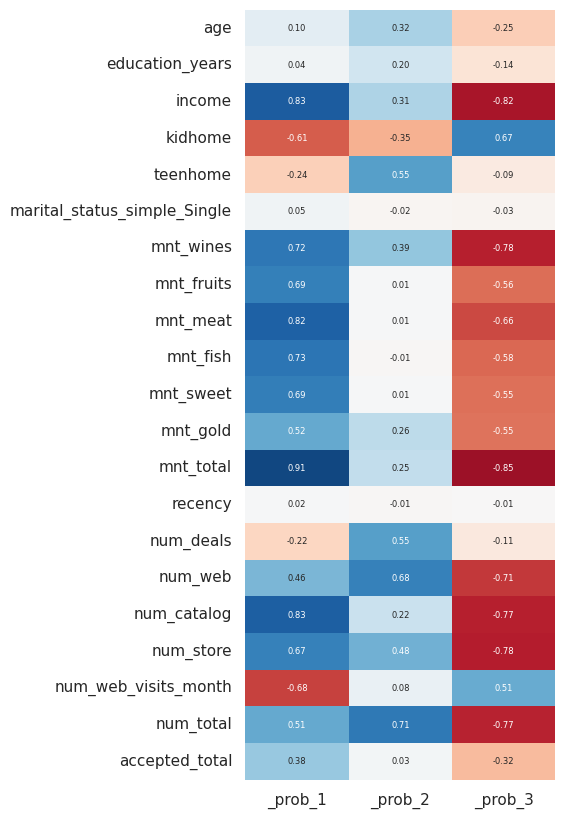

In [223]:
# get correlations 
df_unscaled = pd.get_dummies(df_unscaled, drop_first=False)
df_corr = df_unscaled.corr()
# remove from bottom
df_corr = df_corr.filter(regex="prob", axis=1)
# remove from left
df_corr.drop(["pred_cluster", "_prob_1", "_prob_2", "_prob_3"], axis=0, inplace=True)


from matplotlib import pyplot as plt
import seaborn as sns

def heatmap(df, file_name=None, figsize=(10,5)):

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        df,
        cmap='RdBu',
        annot=True,
        fmt=".2f",
        annot_kws={"size": 6},
        vmin=-1, vmax=1,
        cbar=False
    )

    if file_name is not None:
        # save the plot as JPG file
        #print(f"saving {file_name}")
        plt.savefig(
            file_name,
            dpi=300,
            bbox_inches='tight'
        )
        #plt.xticks(rotation=0)
        plt.show()


heatmap(df_corr,
    file_name=f"output/figures/fig_corrplot_first_look_{n_clusters}_clst_income_pred.png",
    figsize=(4,10)
)

In [224]:
# df_predicted.value_counts("pred_custer")#
df_unscaled["pred_cluster"].value_counts()

pred_cluster
3    1037
2     625
1     578
Name: count, dtype: int64

## PCA

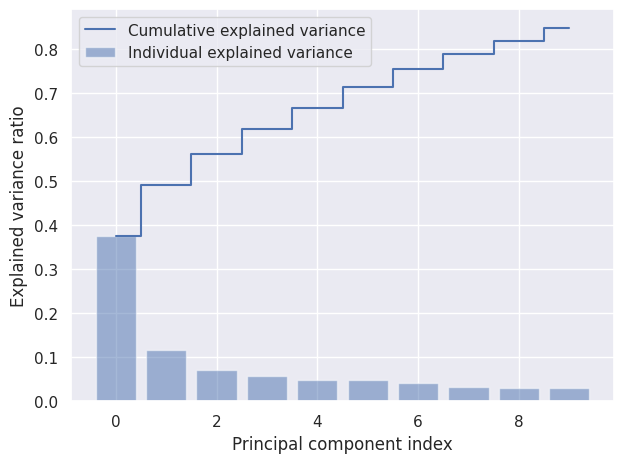

In [225]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit_transform(df_scaled)

exp_var_pca_sng = pca.explained_variance_ratio_
exp_var_pca_sum = np.cumsum(pca.explained_variance_ratio_)

plt.bar(range(0,len(exp_var_pca_sng)), exp_var_pca_sng, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(exp_var_pca_sum)), exp_var_pca_sum, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [226]:
df_scaled.columns

Index(['age', 'education_years', 'income', 'kidhome', 'teenhome', 'marital_status_simple_Single', 'mnt_wines', 'mnt_fruits', 'mnt_meat', 'mnt_fish', 'mnt_sweet', 'mnt_gold', 'mnt_total', 'recency', 'num_deals',
       'num_web', 'num_catalog', 'num_store', 'num_web_visits_month', 'num_total', 'accepted_total'],
      dtype='object')

In [227]:
_pca_1 = df_scaled.dot(pca.components_[0])
_pca_2 = df_scaled.dot(pca.components_[1])

df_unscaled["pca_1"] = _pca_1
df_unscaled["pca_2"] = _pca_2

df_unscaled["pca_1"] = _pca_1
df_reordered["pca_2"] = _pca_2

df_unscaled["_prob_1"] = df_reordered["_prob_1"]
df_unscaled["_prob_2"] = df_reordered["_prob_2"]
df_unscaled["_prob_3"] = df_reordered["_prob_3"]
df_unscaled["pred_cluster"] = df_reordered["pred_cluster"]


In [229]:
df_unscaled.groupby("pred_cluster").mean()

,age,education_years,income,kidhome,teenhome,marital_status_simple_Single,mnt_wines,mnt_fruits,mnt_meat,mnt_fish,mnt_sweet,mnt_gold,mnt_total,recency,num_deals,num_web,num_catalog,num_store,num_web_visits_month,num_total,accepted_total,_prob_1,_prob_2,_prob_3,pca_1,pca_2
pred_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,
1,46.637606,17.100346,76071.560510,0.041522,0.169550,0.380623,613.870242,67.788927,459.401384,99.290657,70.693772,77.766436,1388.811419,49.870242,1.252595,5.119377,5.922145,8.320069,2.785467,23.577855,0.726644,0.418783,0.321380,0.259838,3.668627,-1.108114
2,50.061274,17.857600,57492.373546,0.265600,0.920000,0.329600,454.049600,23.137600,135.456000,30.088000,22.835200,60.132800,725.699200,47.862400,3.912000,6.368000,3.036800,7.689600,5.900147,27.019200,0.252800,0.293824,0.407865,0.298310,0.842740,1.815252
3,43.475356,16.645130,37073.366877,0.776278,0.444552,0.356798,40.711668,5.085824,22.925747,7.581485,5.292189,15.503375,97.100289,49.436837,1.943105,2.076181,0.559306,3.235294,6.307796,14.161041,0.085824,0.226919,0.299622,0.473459,-2.552728,-0.476415


In [230]:
# plot opts
sns.set_theme()
p_pal = sns.color_palette("viridis", as_cmap=True)
p_alpha = 1

<Axes: xlabel='pca_1', ylabel='pca_2'>

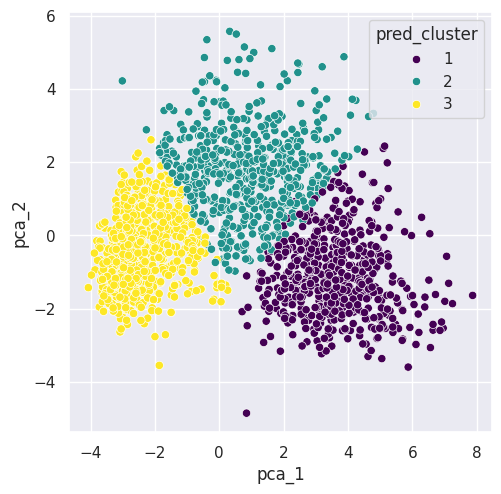

In [284]:
plt.figure(figsize = (12,12))
ax = plt.subplot(2,2,1)
sns.scatterplot(data=df_unscaled, x="pca_1", y="pca_2", hue="pred_cluster", alpha=p_alpha, palette=p_pal)

<Axes: xlabel='pca_1', ylabel='income'>

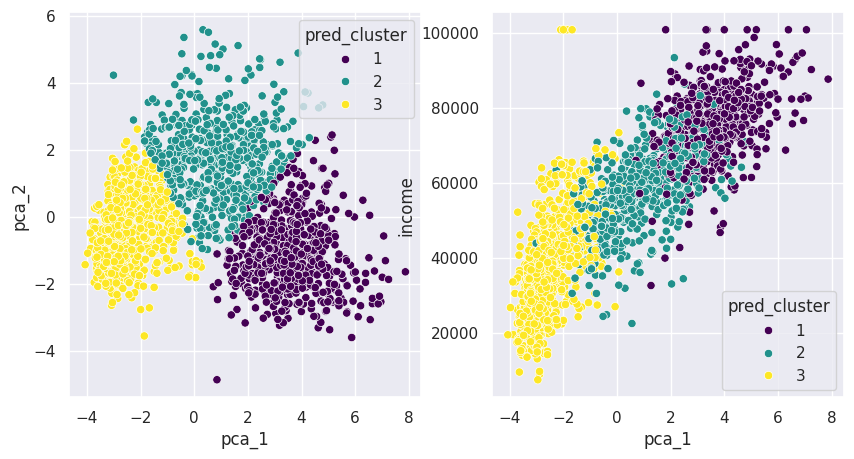

In [285]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax = plt.subplot(1,2,1)
sns.scatterplot(data=df_unscaled, x="pca_1", y="pca_2", hue="pred_cluster",  alpha=p_alpha, palette=p_pal)
ax = plt.subplot(1,2,2)
sns.scatterplot(data=df_unscaled, x="pca_1", y="income", hue="pred_cluster",  alpha=p_alpha, palette=p_pal)

## Summary Stats

In [287]:
def summary_stats_by_group(df, group_var, target_var, sorted=False):
    
    # Calculate the summary statistics
    summary = df.groupby(group_var)[target_var].agg(
        count="count",  # Count the number of occurrences
        mean="mean",
        min="min",
        max="max",
        p05=lambda x: x.quantile(0.05),
        p10=lambda x: x.quantile(0.10),
        p25=lambda x: x.quantile(0.25),
        p50=lambda x: x.quantile(0.50),
        p75=lambda x: x.quantile(0.75),
        p90=lambda x: x.quantile(0.90),
        p95=lambda x: x.quantile(0.95),
    ).reset_index()

    # Sort by mean value (descending order)
    if sorted: summary = summary.sort_values(by="mean", ascending=True)

    return summary.style.hide()

In [289]:
print("income")
summary_stats_by_group(df_unscaled, group_var="pred_cluster", target_var="income")

income


pred_cluster,count,mean,min,max,p05,p10,p25,p50,p75,p90,p95
1,578,76071.560510,32632.000000,100846.143825,61341.200000,63916.600000,70041.750000,76428.500000,82300.500000,88126.100000,92190.150000
2,625,57492.373546,22507.000000,93404.000000,39906.400000,43458.400000,50387.000000,57959.000000,64831.000000,70285.200000,74881.000000
3,1037,37073.366877,7500.000000,100846.143825,18659.200000,22041.800000,27889.000000,36143.000000,44322.000000,54147.000000,61129.157477


In [290]:
print("num_web")
summary_stats_by_group(df_unscaled, group_var="pred_cluster", target_var="num_web")

num_web


pred_cluster,count,mean,min,max,p05,p10,p25,p50,p75,p90,p95
1,578,5.119377,0,11,2.000000,3.000000,4.000000,5.000000,6.000000,8.000000,9.000000
2,625,6.368000,0,11,3.000000,4.000000,5.000000,6.000000,8.000000,10.000000,11.000000
3,1037,2.076181,0,7,1.000000,1.000000,1.000000,2.000000,3.000000,4.000000,4.000000


In [291]:
print("num_web_visits_month")
summary_stats_by_group(df_unscaled, group_var="pred_cluster", target_var="num_web_visits_month")

num_web_visits_month


pred_cluster,count,mean,min,max,p05,p10,p25,p50,p75,p90,p95
1,578,2.785467,0.000000,9.000000,1.000000,1.000000,1.000000,2.000000,4.000000,5.300000,6.000000
2,625,5.900147,0.000000,9.648025,3.000000,3.000000,5.000000,6.000000,7.000000,8.000000,8.000000
3,1037,6.307796,0.000000,9.648025,3.000000,4.000000,5.000000,7.000000,8.000000,8.000000,9.000000


In [245]:
print("age")
summary_stats_by_group(df_unscaled, group_var="pred_cluster", target_var="age")

age


pred_cluster,count,mean,min,max,p05,p10,p25,p50,p75,p90,p95
1,578,46.637606,20.000000,71.648025,25.000000,28.000000,36.000000,46.000000,58.000000,65.000000,68.000000
2,625,50.061274,23.000000,71.648025,35.000000,38.000000,42.000000,50.000000,59.000000,63.000000,65.000000
3,1037,43.475356,19.000000,71.648025,27.000000,29.000000,36.000000,42.000000,50.000000,60.000000,64.000000


In [246]:
print("income")
summary_stats_by_group(df_unscaled, group_var="pred_cluster", target_var="income")

income


pred_cluster,count,mean,min,max,p05,p10,p25,p50,p75,p90,p95
1,578,76071.560510,32632.000000,100846.143825,61341.200000,63916.600000,70041.750000,76428.500000,82300.500000,88126.100000,92190.150000
2,625,57492.373546,22507.000000,93404.000000,39906.400000,43458.400000,50387.000000,57959.000000,64831.000000,70285.200000,74881.000000
3,1037,37073.366877,7500.000000,100846.143825,18659.200000,22041.800000,27889.000000,36143.000000,44322.000000,54147.000000,61129.157477


In [247]:
print("mnt_wines")
summary_stats_by_group(df_unscaled, group_var="pred_cluster", target_var="mnt_wines")

mnt_wines


pred_cluster,count,mean,min,max,p05,p10,p25,p50,p75,p90,p95
1,578,613.870242,1,1493,168.850000,217.000000,367.250000,561.500000,833.000000,1046.500000,1218.000000
2,625,454.049600,1,1459,121.000000,162.000000,235.000000,384.000000,614.000000,889.200000,1037.000000
3,1037,40.711668,0,308,2.000000,3.000000,8.000000,22.000000,54.000000,110.400000,154.000000


In [248]:
print("mnt_fruits")
summary_stats_by_group(df_unscaled, group_var="pred_cluster", target_var="mnt_fruits")

mnt_fruits


pred_cluster,count,mean,min,max,p05,p10,p25,p50,p75,p90,p95
1,578,67.788927,0,197,1.850000,14.000000,26.000000,53.000000,104.750000,148.000000,166.300000
2,625,23.137600,0,199,0.000000,0.000000,4.000000,13.000000,33.000000,61.600000,83.000000
3,1037,5.085824,0,65,0.000000,0.000000,0.000000,2.000000,6.000000,12.000000,19.000000


In [249]:
print("mnt_total")
summary_stats_by_group(df_reordered, group_var="pred_cluster", target_var="mnt_total")

mnt_total


pred_cluster,count,mean,min,max,p05,p10,p25,p50,p75,p90,p95
1,578,1388.811419,277,2525,777.850000,893.400000,1065.250000,1366.000000,1672.000000,1956.300000,2092.000000
2,625,725.699200,8,1829,294.400000,347.400000,448.000000,656.000000,957.000000,1190.200000,1371.000000
3,1037,97.100289,5,473,17.000000,22.000000,38.000000,64.000000,129.000000,231.000000,279.800000


In [250]:
print("accepted_total")
summary_stats_by_group(df_reordered, group_var="pred_cluster", target_var="accepted_total")

accepted_total


pred_cluster,count,mean,min,max,p05,p10,p25,p50,p75,p90,p95
1,578,0.726644,0,4,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000
2,625,0.252800,0,4,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
3,1037,0.085824,0,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [251]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

def plot_violin_strip_matrix_auto(df, group_var, target_vars, figsize=(9, 7), jitter=True, cut=0):
    """
    Creates a matrix of violin and strip plots for multiple target variables,
    with rows and columns determined automatically.
    """
    num_vars = len(target_vars)
    cols = math.ceil(math.sqrt(num_vars))  # Number of columns
    rows = math.ceil(num_vars / cols)     # Number of rows

    # Create the grid of subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

    for i, target_var in enumerate(target_vars):
        if i < len(axes):
            ax = axes[i]  # Select subplot
            sns.violinplot(
                x=target_var, y=group_var, data=df, cut=cut, ax=ax, hue=group_var
            )
            if jitter:
                sns.stripplot(
                    x=target_var, y=group_var, data=df,
                    color="black", size=3, alpha=0.1, jitter=0.2, ax=ax
                )
            ax.set_title(f"Distribution of {target_var}")
            ax.set(xlabel=None, ylabel=None)
        else:
            axes[i].axis("off")  # Hide unused subplots

    # Turn off any remaining unused subplots
    for i in range(num_vars, len(axes)):
        axes[i].axis("off")

    plt.show()


In [268]:
df_reordered['pred_cluster_cat'] = pd.Categorical(df_reordered["pred_cluster"])
df_unscaled['pred_cluster_cat'] = pd.Categorical(df_unscaled["pred_cluster"])

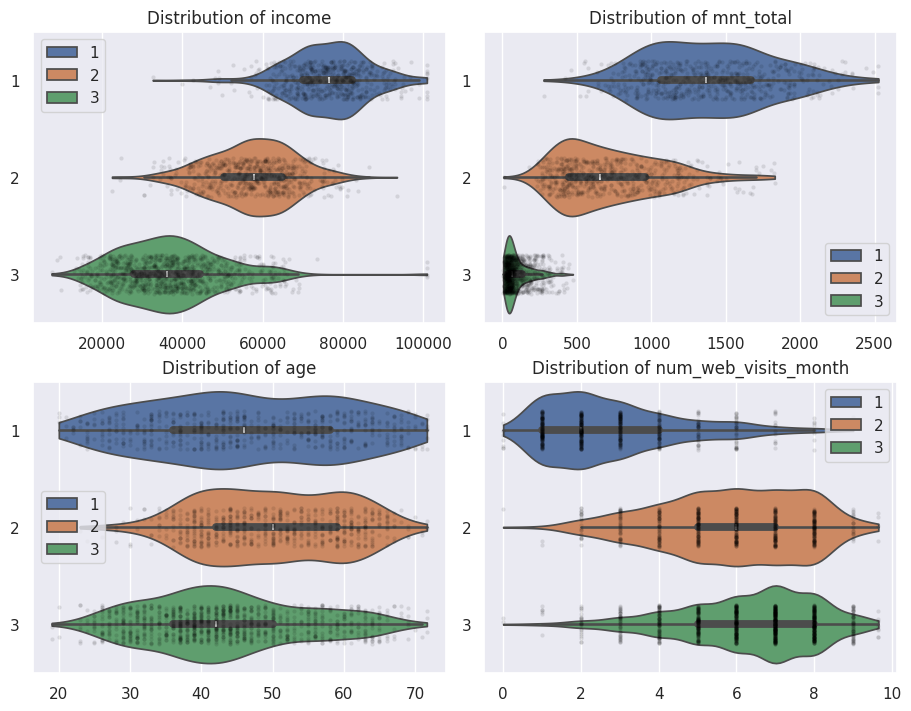

In [270]:
target_vars = ["income", "mnt_total", "age",  "num_web_visits_month"]
plot_violin_strip_matrix_auto(df_unscaled, group_var='pred_cluster_cat', target_vars=target_vars)

<Axes: xlabel='pca_2', ylabel='income'>

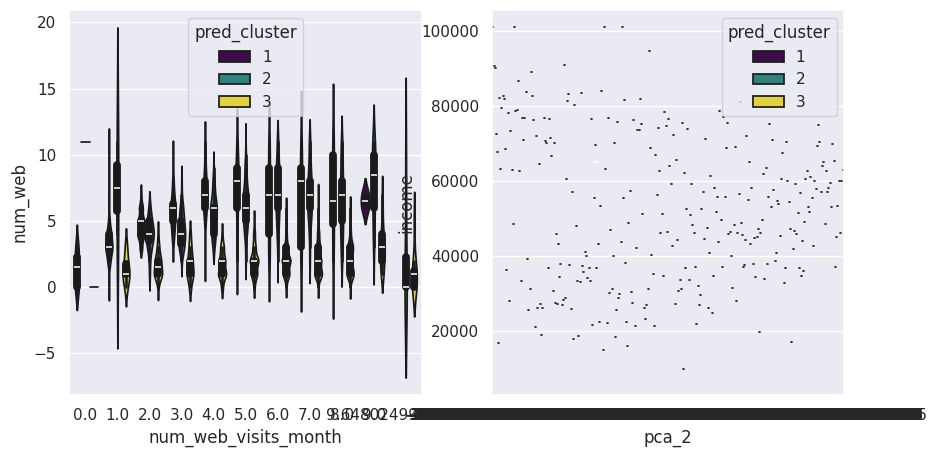

In [278]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5)) 
ax = plt.subplot(1,2,1)
sns.violinplot(data=df_unscaled, x="num_web_visits_month", y="num_web", hue="pred_cluster",  alpha=p_alpha, palette=p_pal)


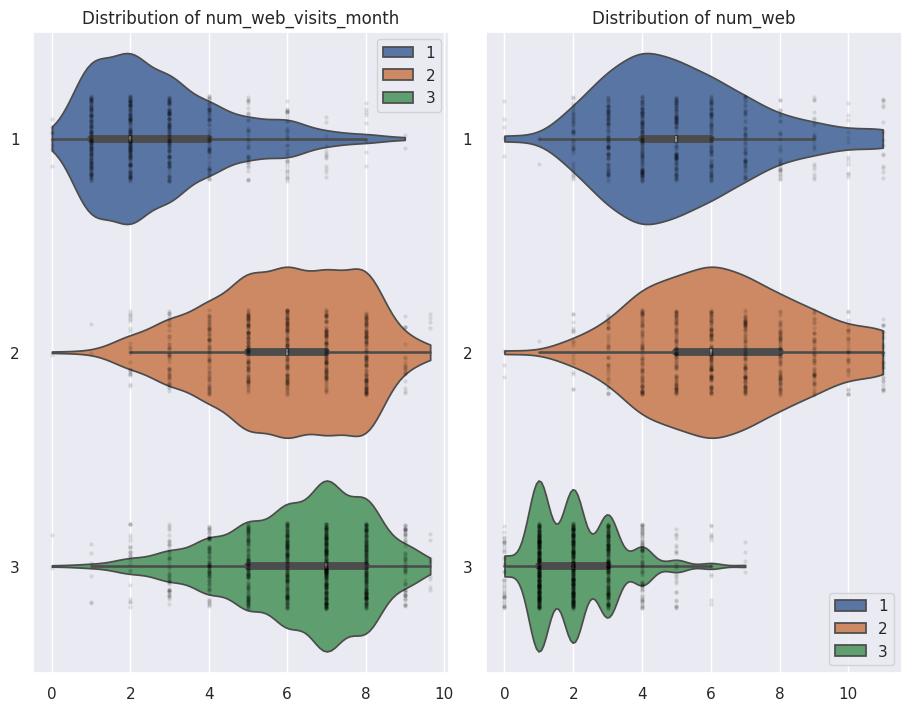

In [279]:
target_vars = ["num_web_visits_month", "num_web"]
plot_violin_strip_matrix_auto(df_unscaled, group_var='pred_cluster_cat', target_vars=target_vars)

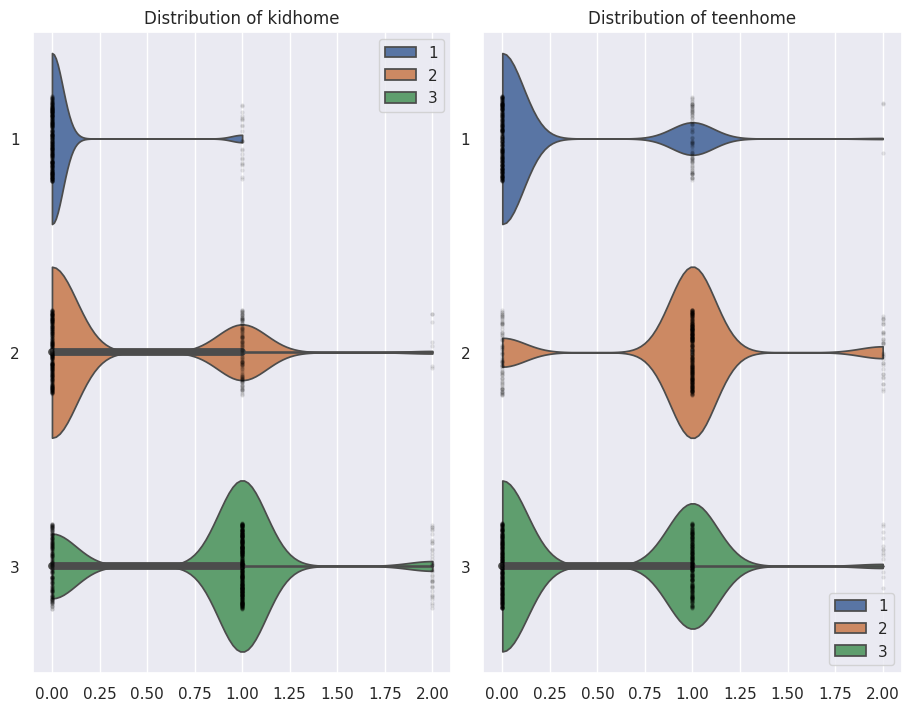

In [271]:
target_vars = ['kidhome', 'teenhome']
plot_violin_strip_matrix_auto(df_unscaled, group_var='pred_cluster_cat', target_vars=target_vars)

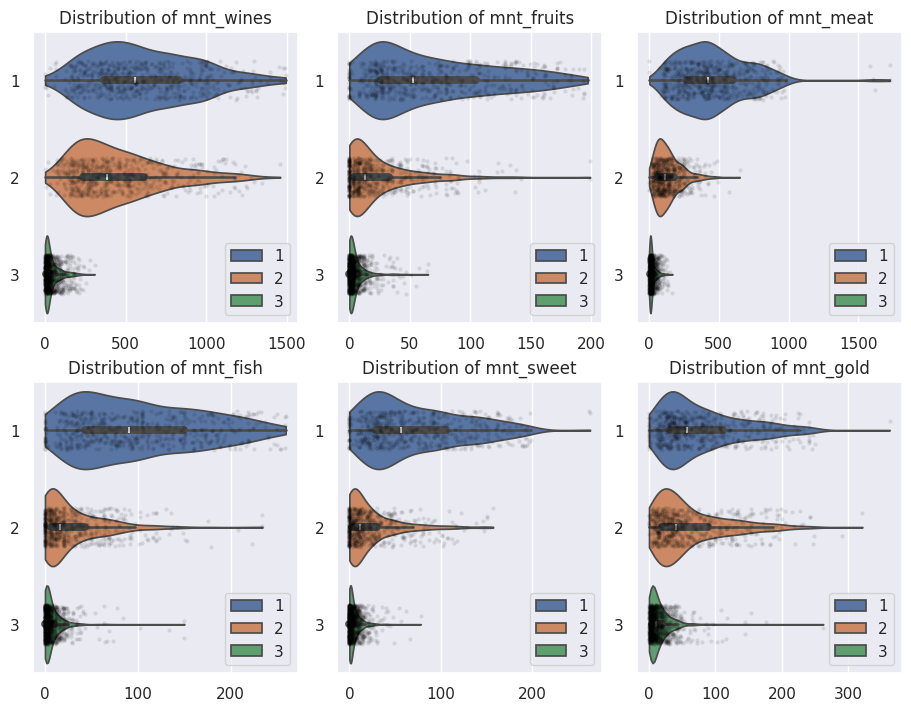

In [272]:
target_vars = ['mnt_wines', 'mnt_fruits', 'mnt_meat', 'mnt_fish', 'mnt_sweet', 'mnt_gold']
plot_violin_strip_matrix_auto(df_reordered, group_var='pred_cluster_cat', target_vars=target_vars)

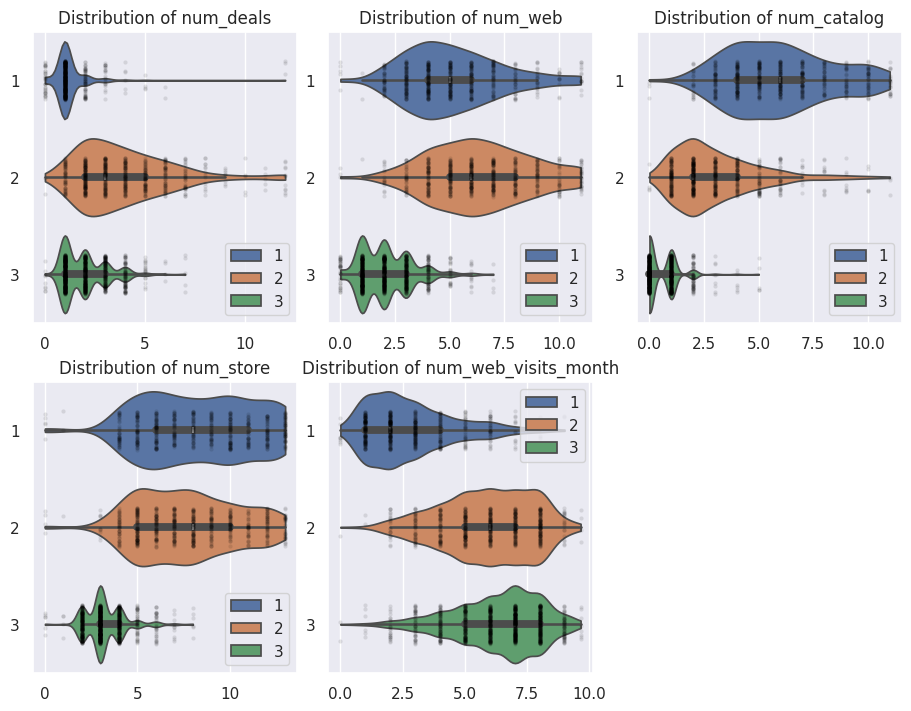

In [273]:
target_vars = ['num_deals', 'num_web', 'num_catalog', 'num_store', 'num_web_visits_month']
plot_violin_strip_matrix_auto(df_reordered, group_var='pred_cluster_cat', target_vars=target_vars)